In [364]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [365]:
import molten_data_common_lib
importlib.reload(molten_data_common_lib)
from molten_data_common_lib import (glob_file_list , load_json_from_file, merge_dicts, plot_groups, 
                                    get_varying_column_names, filter_dataframe,
                                    load_json_records_as_dataframe)

In [366]:
src_files = []
# src_files += ['../p3_test_driver/data/results/json/*cfa64651-ac9a-4ab4-b4f1-0fa24cfe3fdc*.json']
src_files += ['../p3_test_driver/data/results/json/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 49 files...


In [367]:
#raw_df.iloc[0].driver['client']['persistence']

In [368]:
def clean_result(result):
    try:
        r = result.copy()
        r['driverName'] = r['driver']['name']
        r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
r = clean_result(raw_df.iloc[0])
pd.DataFrame(r)

,0
build,False
command_timed_out,False
driver,Pulsar
elapsed_sec,370.363
error,False
...,...
publishRateMBPerSecMean,30.073
publishLatencyMsAvg,2.85502
publishLatencyMs99Pct,4.193
endToEndLatencyMsAvg,8.60811


In [369]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

ERROR: 47e915a0-0587-461e-bb77-b513da507827: 'float' object is not iterable
ERROR: 206ae585-349e-4c11-a06e-4c0d4ae640fe: 'float' object is not iterable
ERROR: d9aac910-c6db-497a-a02b-ead8a626745f: 'float' object is not iterable
ERROR: 564733b2-b071-4a02-8350-f82e636b6bfa: 'float' object is not iterable


In [370]:
clean_df.columns.values

array(['build', 'command_timed_out', 'driver', 'elapsed_sec', 'error',
       'errors', 'exit_code', 'git_commit', 'loaded_filename',
       'localWorker', 'max_test_attempts', 'noop', 'numWorkers',
       'omb_results', 'omb_workers', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'ssh_host',
       'ssh_identity_file', 'ssh_user', 'status_html', 'tarball', 'test',
       'test_attempt', 'test_batch_uuid', 'test_desc',
       'test_driver_log_filename', 'test_driver_version', 'test_uuid',
       'undeploy', 'utc_begin', 'utc_end', 'driverName', 'ackQuorum',
       'deduplicationEnabled', 'ensembleSize', 'writeQuorum',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', 'topics',
       'aggregat

In [371]:
info_cols = [
    'numWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',    
]

In [372]:
cols = [
    'messageSize',
    'numWorkloadWorkers',
    'producersPerTopic',
    'partitionsPerTopic',
    'testDurationMinutes',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'ackQuorum',
    'throttleEventsPerSec',
    #'deduplicationEnabled',
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMsAvg',
    'publishLatencyMs99Pct',
    'endToEndLatencyMsAvg',
    'endToEndLatencyMs99Pct',
    'utc_begin',
]

In [373]:
clean_df[cols].tail(2).T

test_uuid,1d82b3c9-98ba-4a17-9618-a5877d71b4ff,05f37f06-ff0d-4ba0-9649-04c39c5fcb9f
messageSize,10000,10000
numWorkloadWorkers,4,4
producersPerTopic,4,4
partitionsPerTopic,16,16
testDurationMinutes,5,5
subscriptionsPerTopic,1,1
consumerPerSubscription,16,16
ackQuorum,2,2
throttleEventsPerSec,30000,-1
publishRateEventsPerSecMean,30109.7,36476.4


In [374]:
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [375]:
df = clean_df[cols]
df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
df.head()

,messageSize,numWorkloadWorkers,producersPerTopic,partitionsPerTopic,testDurationMinutes,subscriptionsPerTopic,consumerPerSubscription,ackQuorum,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,,,,,,
22b9ab65-0c50-4180-a6d9-454998ab5bb8,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,4.034625e+05,40.346246,0.000000,0.000,0.000000,0.000,2019-09-29T17:05:37.792852
40bdbe3c-18ed-48b8-a88e-cd719f04eda2,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,1.225671e+06,122.567110,4.041255,4.867,0.000000,0.000,2019-09-29T17:14:05.238724
79b21aa6-9b35-4a31-8ef1-94fb8664c41b,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,1.367346e+06,136.734587,4.143735,4.963,0.000000,0.000,2019-09-29T17:21:08.078498
25ac50a5-8fb3-451f-b925-57ab2f54b158,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,9.526471e+05,95.264706,7.506097,35.051,13561.878498,15385.023,2019-09-29T17:31:52.498934
7a8c6fe9-b353-4e35-9a6b-24e0cb4ecf28,100.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,9.930919e+05,99.309189,7.174837,33.027,16009.838414,21974.015,2019-09-29T17:34:39.332250


In [388]:
messageSize = 10000
filt_df = filter_dataframe(
    clean_df,
    driverName='Pulsar',
    messageSize=messageSize, 
    numWorkloadWorkers=4, 
    producersPerTopic=4,
    partitionsPerTopic=16,
    deduplicationEnabled=True,
    testDurationMinutes=5,
    
)
filt_df[cols].sort_values(['publishRateMBPerSecMean'], ascending=False)

,messageSize,numWorkloadWorkers,producersPerTopic,partitionsPerTopic,testDurationMinutes,subscriptionsPerTopic,consumerPerSubscription,ackQuorum,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,,,,,,
05f37f06-ff0d-4ba0-9649-04c39c5fcb9f,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,-1.0,36476.419604,364.764196,3905.499259,7263.263,0.000000,0.0,2019-09-30T16:44:06.813100
1d82b3c9-98ba-4a17-9618-a5877d71b4ff,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,30000.0,30109.721952,301.097220,4.449003,22.102,10.619343,64.0,2019-09-30T16:37:51.102107
4b9942f6-1e63-49a7-a14b-253825411ae3,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,10000.0,10009.857208,100.098572,3.223861,4.603,8.620528,14.0,2019-09-30T16:31:35.934092
f8cb8cd2-51b0-4c5d-bf16-08f0013b5cdd,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,3000.0,3005.130997,30.051310,2.908318,4.231,8.141900,14.0,2019-09-30T16:25:19.739047
5dedf070-dcdb-4001-8f26-3240b6748743,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,1000.0,1000.710723,10.007107,2.967763,4.199,5.843620,13.0,2019-09-30T16:19:04.494857
b6ea2279-62da-46a7-863e-fa79cca0b2eb,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,300.0,300.399464,3.003995,3.148807,4.275,3.865883,11.0,2019-09-30T16:12:47.177130
5012c4cf-540f-49fe-b665-3c40884c3d8b,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,100.0,100.057774,1.000578,3.122796,4.331,4.148495,13.0,2019-09-30T16:06:31.998671
17a3cd93-194c-408d-941a-f9236b200a41,10000.0,4.0,4.0,16.0,5.0,1.0,16.0,2.0,30.0,30.021332,0.300213,3.302345,4.426,3.634047,5.0,2019-09-30T16:00:15.028153


In [389]:
plot_df = (filt_df
    .set_index(['publishRateMBPerSecMean'])
    .sort_index()
    [[
        'aggregatedPublishLatency50pct',
        'aggregatedPublishLatency95pct',
        'aggregatedPublishLatency99pct',
        'aggregatedEndToEndLatency50pct',
        'aggregatedEndToEndLatency95pct',
        'aggregatedEndToEndLatency99pct',
        'test_uuid',
    ]]
    .rename(columns=dict(
        aggregatedPublishLatency50pct='Publish Latency p50',
        aggregatedPublishLatency95pct='Publish Latency p95',
        aggregatedPublishLatency99pct='Publish Latency p99',
        aggregatedEndToEndLatency50pct='E2E Latency p50',
        aggregatedEndToEndLatency95pct='E2E Latency p95',
        aggregatedEndToEndLatency99pct='E2E Latency p99',
    ))
    )
plot_df.index.name = 'Publish Throughput (MB/s)'
plot_df

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.300213,3.255,4.248,4.426,3.0,5.0,5.0,17a3cd93-194c-408d-941a-f9236b200a41
1.000578,3.116,4.170,4.331,3.0,12.0,13.0,5012c4cf-540f-49fe-b665-3c40884c3d8b
3.003995,3.116,4.095,4.275,3.0,5.0,11.0,b6ea2279-62da-46a7-863e-fa79cca0b2eb
10.007107,2.936,4.028,4.199,4.0,12.0,13.0,5dedf070-dcdb-4001-8f26-3240b6748743
30.051310,2.828,4.024,4.231,8.0,13.0,14.0,f8cb8cd2-51b0-4c5d-bf16-08f0013b5cdd
100.098572,3.063,4.301,4.603,8.0,13.0,14.0,4b9942f6-1e63-49a7-a14b-253825411ae3
301.097220,3.924,5.347,22.102,9.0,14.0,64.0,1d82b3c9-98ba-4a17-9618-a5877d71b4ff
364.764196,4093.743,6307.903,7263.263,0.0,0.0,0.0,05f37f06-ff0d-4ba0-9649-04c39c5fcb9f


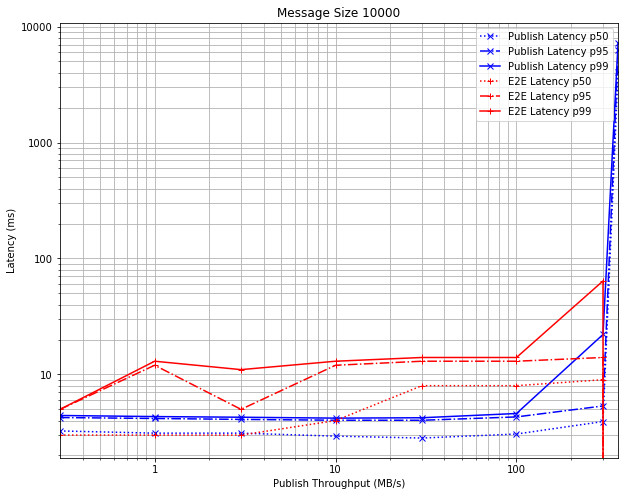

In [390]:
title = 'Message Size %d' % (messageSize)
ax = plot_df.plot(    
    logx=True, 
    logy=True,
    figsize=(10,8), 
    grid=True, 
    title=title, 
    style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
ax.set_ylabel('Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax.xaxis.set_major_formatter(tick_formatter)
ax.yaxis.set_major_formatter(tick_formatter)
ax.grid('on', which='both', axis='both')

In [391]:
filt_df[info_cols].drop_duplicates().T

test_uuid,17a3cd93-194c-408d-941a-f9236b200a41,1d82b3c9-98ba-4a17-9618-a5877d71b4ff
numWorkers,4,4
topics,1,1
partitionsPerTopic,16,16
producersPerTopic,4,4
subscriptionsPerTopic,1,1
consumerPerSubscription,16,16
testDurationMinutes,5,5
keyDistributor,NO_KEY,NO_KEY
git_commit,5d7c77a Updated P3 Test Driver SSH,133e19e Copied driver-pulsar/deploy to driver-...


In [380]:
# plot_groups(
#     filt_df, 
#     x_col='publishRateEventsPerSecMean',
#     y_col='publishLatencyMs99Pct',
#     group_by_columns=['partitionsPerTopic', 'messageSize'],
#     semilogx=True,
# #     ylim=[0,100],
# );

# Analyze Latency Distribution

In [381]:
df = clean_df
df = df[df.test_uuid=='cfa64651-ac9a-4ab4-b4f1-0fa24cfe3fdc']
t = df.iloc[0]
t

build                        False
command_timed_out            False
driver                      Pulsar
elapsed_sec                972.281
error                        False
                            ...   
publishRateMBPerSecMean    5.00089
publishLatencyMsAvg        2.90988
publishLatencyMs99Pct         4.09
endToEndLatencyMsAvg       3.42642
endToEndLatencyMs99Pct          12
Name: cfa64651-ac9a-4ab4-b4f1-0fa24cfe3fdc, Length: 103, dtype: object

In [382]:
# Cumulative Distribution Function
cdf = t.aggregatedPublishLatencyQuantiles
cdf

0.645      4.424505e-08
1.003      5.024490e-03
1.169      1.001436e-02
1.320      1.500031e-02
1.468      2.003252e-02
               ...     
220.531    9.999999e-01
220.532    9.999999e-01
220.533    1.000000e+00
220.534    1.000000e+00
222.364    1.000000e+00
Length: 1640, dtype: float64

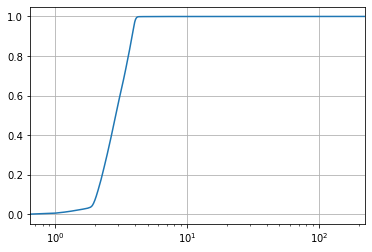

In [383]:
cdf.plot(logx=True, grid=True);

In [384]:
# Probability Distribution Function (latency histogram)
pdf = pd.Series(index=cdf.index, data=np.gradient(cdf, cdf.index.values))
pdf

0.645      1.403476e-02
1.003      2.498292e-02
1.169      3.160953e-02
1.320      3.351541e-02
1.468      3.376274e-02
               ...     
220.531    4.424505e-05
220.532    4.424505e-05
220.533    3.318379e-05
220.534    2.211045e-05
222.364    1.208881e-08
Length: 1640, dtype: float64

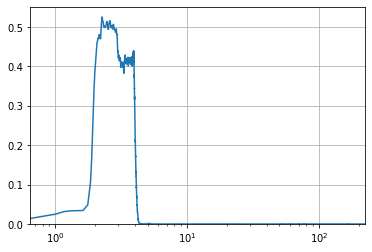

In [385]:
pdf.plot(logx=True, logy=False, grid=True, ylim=[0,None]);

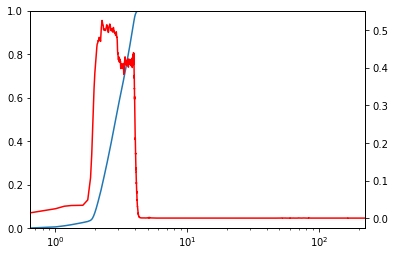

In [386]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
cdf.plot(ax=ax0, logx=True, ylim=[0,1])
pdf.plot(secondary_y=True, ylim=[0,None], ax=ax1, style='r')
plt.show()
plt.close()

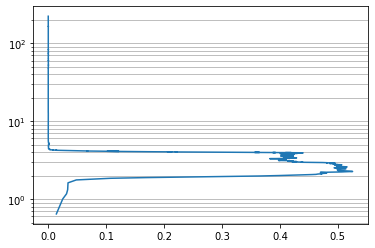

In [387]:
fig0, ax0 = plt.subplots()
ax0.plot(pdf.values, pdf.index.values)
ax0.grid('on', which='both', axis='y')
ax0.semilogy(True);